# Working with `pandas` Data Frames
## Abstract
The report demonstrates how to use `pandas` to join and analyse multiple datasets from the 2017 `myki` tram records. By combining touch-on, touch-off, and stop location data, we construct complete passenger journey and apply aggregation techniques to extract insights. The analysis identifies the top 10 busiest stops, the busiest tram routes, and the longest routes based on average end-to-end travel time. Through these examples, the report illustrates how effective data joining and summarization with `pandas` enables meaningful interpretation of transport usage patterns.

## Demonstration
### 1. Prepare Data
In this section, we will load dataset from three different data files.

In [2]:
import pandas as pd

# Read CSV files
scanOnTransactions = pd.read_csv('data/myki/myki_2017_top20_tram_routes_ScanOnTransaction.csv')
print(scanOnTransactions.head(1))

scanOffTransactions = pd.read_csv('data/myki/myki_2017_top20_tram_routes_ScanOffTransaction.csv')
print(scanOffTransactions.head(1))

   mode business_date  card_id  card_type  vehicle_id  parent_route  route_id  \
0     3    2017-02-15  7639560          1         638            59     16852   

   stop_id            date_time  
0    19256  2017-02-15 08:57:13  
   mode business_date   card_id  card_type  vehicle_id  parent_route  \
0     3    2017-03-31  18827590          1         656            86   

   route_id  stop_id            date_time  
0     19716    18038  2017-03-31 11:52:38  


By comparing the stop information with [Yarra Trams’ official route guides](https://yarratrams.com.au/route-guides) and verifying locations in [Google Maps](https://www.google.com/), we determined that the stop data is delimited by `|` and follows the field order: StopID, StopNameShort, StopNameLong, StopType, Suburb, Postcode, City, LGA, Region, Latitude, and Longitude.

In [3]:
# Read TXT file
stops = pd.read_csv("data/myki/stop_locations.txt", sep="|", names=[
    "StopID",
    "StopNameShort",
    "StopNameLong",
    "StopType",
    "Suburb",
    "Postcode",
    "City",
    "LGA",
    "Region",
    "Latitude",
    "Longitude"
])
print(stops.head(1))

   StopID  StopNameShort                                StopNameLong  \
0     867  Weemala Court  Weemala Ct/Plenty River Dr (Greensborough)   

   StopType         Suburb  Postcode       City      LGA         Region  \
0  Kerbside  Greensborough    3088.0  Melbourne  Banyule  Greater Metro   

    Latitude   Longitude  
0 -37.689596  145.105088  


After loading the datasets, the next step is to link each transaction with its corresponding stop details to provide meaningful context for both touch-on and touch-off events.

In [4]:
scanOnTransactions = scanOnTransactions.merge(
    stops[["StopID", "StopNameLong"]],
    left_on="stop_id",
    right_on="StopID",
    how="left"
).rename(columns={
    "StopID": "StopNumber_on",
    "StopNameLong": "StopNameLong_on"
})

print(scanOnTransactions.head(1))

   mode business_date  card_id  card_type  vehicle_id  parent_route  route_id  \
0     3    2017-02-15  7639560          1         638            59     16852   

   stop_id            date_time  StopNumber_on  \
0    19256  2017-02-15 08:57:13        19256.0   

                                     StopNameLong_on  
0  19-Royal Childrens Hospital/Flemington Rd (Nor...  


In [5]:
scanOffTransactions = scanOffTransactions.merge(
    stops[["StopID", "StopNameLong"]],
    left_on="stop_id",
    right_on="StopID",
    how="left"
).rename(columns={
    "StopID": "StopNumber_off",
    "StopNameLong": "StopNameLong_off"
})
print(scanOffTransactions.head(1))

   mode business_date   card_id  card_type  vehicle_id  parent_route  \
0     3    2017-03-31  18827590          1         656            86   

   route_id  stop_id            date_time  StopNumber_off  \
0     19716    18038  2017-03-31 11:52:38         18038.0   

                                   StopNameLong_off  
0  D11-Waterfront City/434 Docklands Dr (Docklands)  


At this stage, we have complete records for both passenger touch-on and touch-off events. By joining the datasets using `card_id`, `business_date`, `route_id`, and `vehicle_id`, we can identify when a passenger (card_id) travelled (business_date), which route they used (route_id), which vehicle they boarded (vehicle_id), as well as the specific stops where they touched on and touched off.

In [6]:
merged = scanOnTransactions.merge(
    scanOffTransactions,
    on=["card_id", "business_date", "route_id", "vehicle_id"],
    how="left",
    suffixes=("_on", "_off")  # avoid name collision
)

final = merged[["business_date", "card_id", "route_id", "vehicle_id", "stop_id_on", "date_time_on", "StopNameLong_on",
                "stop_id_off", "date_time_off", "StopNameLong_off"]]
print(final[final["stop_id_off"].notna()].head(1))

  business_date   card_id  route_id  vehicle_id  stop_id_on  \
5    2017-01-04  16700780     17885         701       18449   

          date_time_on                      StopNameLong_on  stop_id_off  \
5  2017-01-04 07:50:33  32-Chapel St/Dandenong Rd (Windsor)      19678.0   

         date_time_off                                   StopNameLong_off  
5  2017-01-04 07:59:55  20-Domain Interchange/St Kilda Rd (Melbourne C...  


### 2. Identify top 10 busiest stops
In this section, we identify the top 10 busiest stops based on the yearly average number of touch-on transactions. To begin, we group the data by `stop_id_on` and `StopNameLong_on` to calculate the total number of touch-on events at each stop.

In [7]:
touch_on_counts = (
    final.groupby(["stop_id_on", "StopNameLong_on"])
    .size()
    .reset_index(name="touch_on_count")
    .sort_values("touch_on_count", ascending=False)
)

top10 = touch_on_counts.head(10)
print(top10)

      stop_id_on                                    StopNameLong_on  \
1271       19696       1-Melbourne University/Swanston St (Carlton)   
346        17877  1-Flinders Street Railway Station/Elizabeth St...   
1189       19499  13-Federation Square/Swanston St (Melbourne City)   
1183       19491             3-Lincoln Square/Swanston St (Carlton)   
1266       19689  8-Melbourne Central Station/Swanston St (Melbo...   
1300       19725        129-Beacon Cove/Light Rail (Port Melbourne)   
1352       19781       58-Box Hill Central/Whitehorse Rd (Box Hill)   
1181       19482        59-Airport West/Matthews Ave (Airport West)   
1187       19497  10-Bourke Street Mall/Swanston St (Melbourne C...   
759        18663     32-Beaconsfield Pde/Victoria Ave (Albert Park)   

      touch_on_count  
1271           64475  
346            47375  
1189           42513  
1183           37135  
1266           35205  
1300           29942  
1352           22227  
1181           22211  
1187       

Using bar chart to show the top 10 busiest stops, order by stops numbers descend.

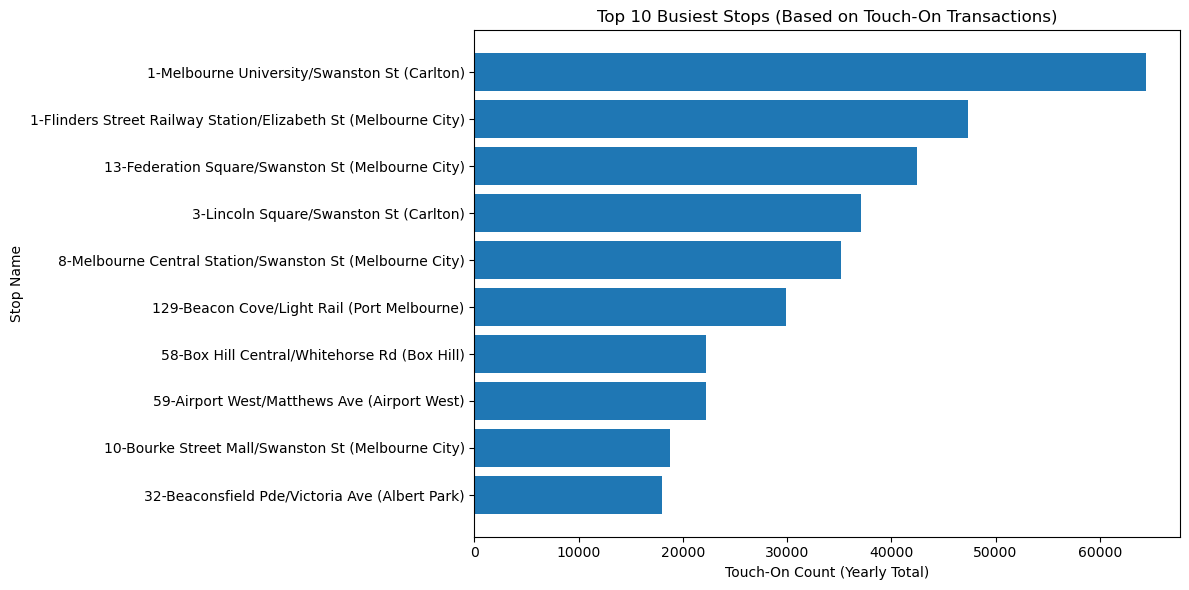

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(top10["StopNameLong_on"], top10["touch_on_count"])
plt.xlabel("Touch-On Count (Yearly Total)")
plt.ylabel("Stop Name")
plt.title("Top 10 Busiest Stops (Based on Touch-On Transactions)")
plt.gca().invert_yaxis()  # Largest at top
plt.tight_layout()
plt.show()

### 3. Identify the top 10 busiest tram routes
In this section, we identify the top 10 busiest tram routes based on the yearly average number of passengers per day, calculate the average number of touch-ons per hour across all days, and use the identified peak windows to determine the average number of touch-ons during the morning and afternoon peak periods for each route.
1. Identify the top 10 busiest tram routes.
2. Calculate the average hourly touch-on counts for these routes.
3. Use the peak windows to compute the average number of touch-ons during the morning and afternoon peaks.

We begin by counting the total number of passengers for each tram route on each day.

In [9]:
daily_counts = (
    final.groupby(["route_id", "business_date"])
    .size()
    .reset_index(name="daily_passengers")
)

print(daily_counts.head(1))

   route_id business_date  daily_passengers
0      1413    2017-01-26                48


Based on this daily passenger dataset, we then calculate the yearly average number of passengers per day for each tram route. Then, sort the dataset.

In [10]:
route_avg = (
    daily_counts.groupby("route_id")["daily_passengers"]
    .mean()
    .reset_index(name="avg_passengers_per_day")
)

print(route_avg.head(1))

   route_id  avg_passengers_per_day
0      1413                    35.5


In [11]:
top10_routes = route_avg.sort_values(
    "avg_passengers_per_day", ascending=False
).head(10)

print(top10_routes)

      route_id  avg_passengers_per_day
1061     31467              299.273504
207      16588              275.873362
979      30929              268.811966
19        1455              259.625000
638      19670              231.421053
474      17872              212.116883
863      24515              207.507463
997      30968              206.728070
526      18479              204.810345
971      24688              190.025862


A bar chart is used to display the top 10 busiest tram routes, ordered in descending order of average passengers per day.

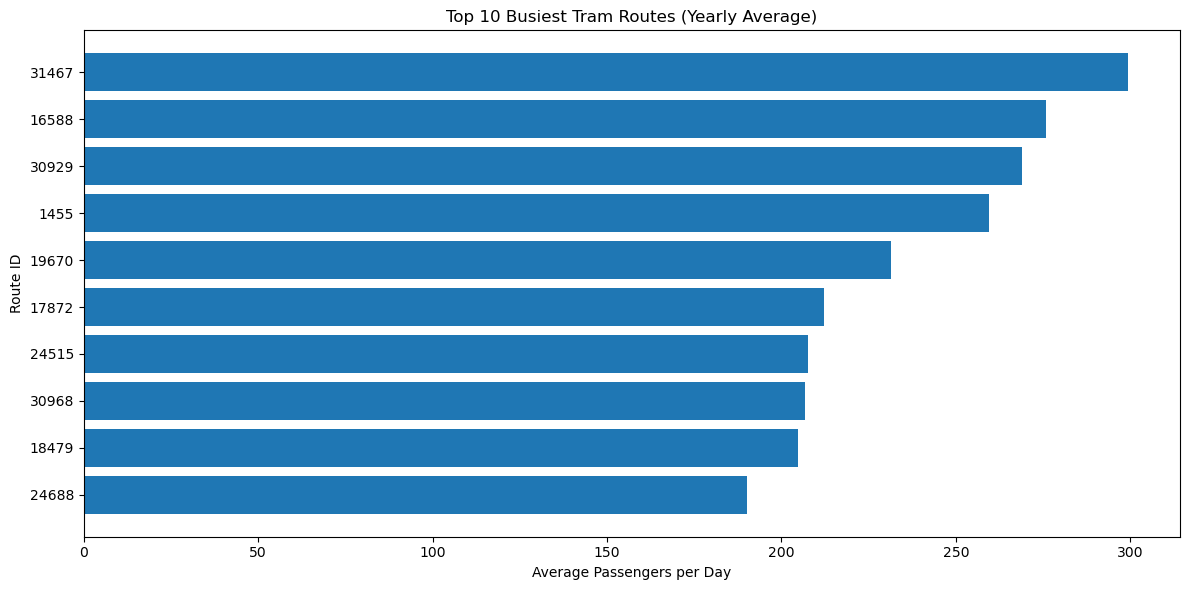

In [12]:
plt.figure(figsize=(12, 6))
plt.barh(
    top10_routes["route_id"].astype(str),
    top10_routes["avg_passengers_per_day"]
)

plt.xlabel("Average Passengers per Day")
plt.ylabel("Route ID")
plt.title("Top 10 Busiest Tram Routes (Yearly Average)")
plt.gca().invert_yaxis()  # largest at top
plt.tight_layout()
plt.show()

#### Calculate the average hourly touch-on counts for these routes
Add a new column to the dataset that extracts the hour of the day from each touch-on timestamp.

In [13]:
df = final.copy()

# convert to datetime
df["date_time_on"] = pd.to_datetime(df["date_time_on"])

# extract hour (0–23)
df["hour"] = df["date_time_on"].dt.hour

hourly_counts = (
    df.groupby(["route_id", "business_date", "hour"])
    .size()
    .reset_index(name="touch_on_count")
)
print(hourly_counts.head(1))

   route_id business_date  hour  touch_on_count
0      1413    2017-01-26     8               2


Calculate the average number of touch-on per hour across all days.

In [15]:
avg_hourly_route = (
    hourly_counts.groupby(["route_id", "hour"])["touch_on_count"]
    .mean()
    .reset_index(name="avg_touch_ons")
)

print(avg_hourly_route.head(1))

   route_id  hour  avg_touch_ons
0      1413     0            5.0


Plot the results in a line graph with hour of day on the x-axis and average touch-ons on the y-axis with one line per route.

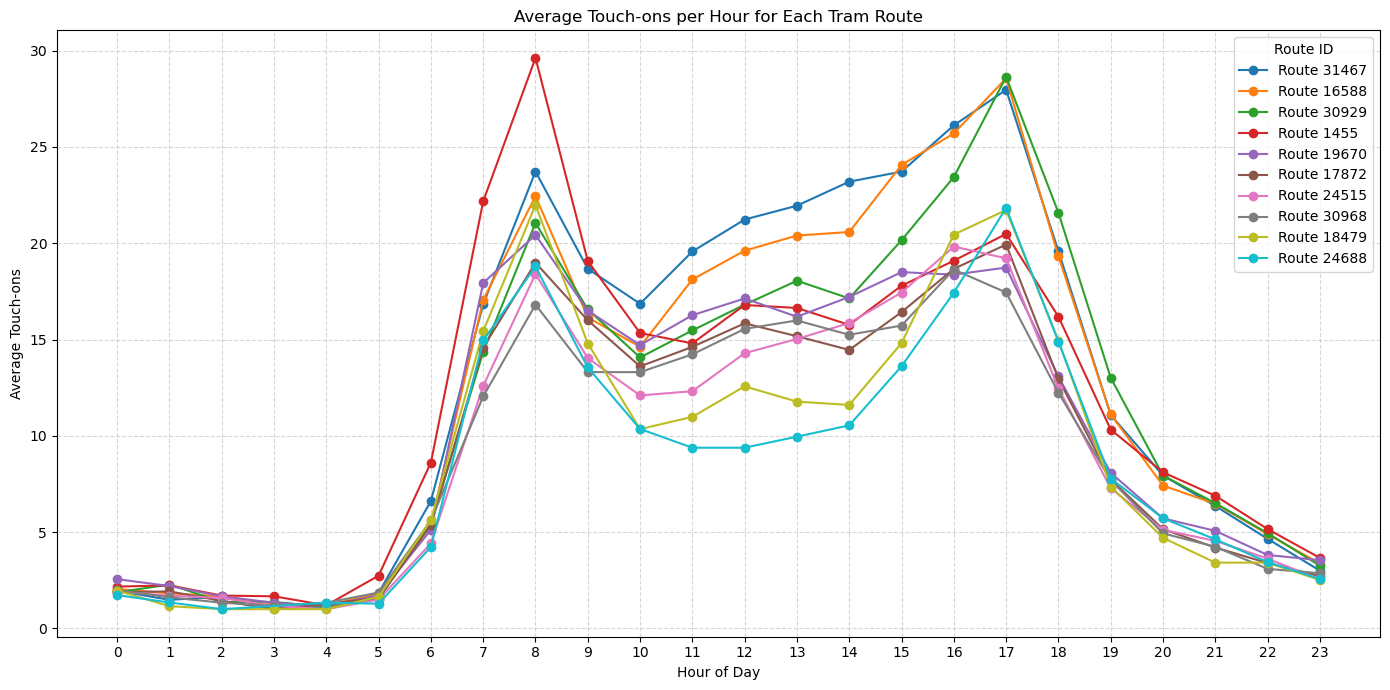

In [16]:
plt.figure(figsize=(14, 7))

for route in top10_routes["route_id"]:
    subset = avg_hourly_route[avg_hourly_route["route_id"] == route]
    plt.plot(subset["hour"], subset["avg_touch_ons"], marker="o", label=f"Route {route}")

plt.xlabel("Hour of Day")
plt.ylabel("Average Touch-ons")
plt.title("Average Touch-ons per Hour for Each Tram Route")
plt.xticks(range(0, 24))
plt.legend(title="Route ID")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

From this line chart, we can identify the approximate morning peak windows is from 7 to 9 hour and the approximate afternoon peak windows is from 16 to 18,

#### Use the peak windows to compute the average number of touch-ons

In [17]:
morning = hourly_counts[hourly_counts["hour"].isin([7, 8, 9])]

avg_morning = (
    morning.groupby("route_id")["touch_on_count"]
    .mean()
    .reset_index(name="avg_morning_touch_ons")
)

In [18]:
afternoon = hourly_counts[hourly_counts["hour"].isin([16, 17, 18])]

avg_afternoon = (
    afternoon.groupby("route_id")["touch_on_count"]
    .mean()
    .reset_index(name="avg_afternoon_touch_ons")
)

In [19]:
route_peaks = avg_morning.merge(
    avg_afternoon,
    on="route_id",
    how="outer"
).fillna(0)

print(route_peaks.head(1))

   route_id  avg_morning_touch_ons  avg_afternoon_touch_ons
0      1413                    2.0                      7.0


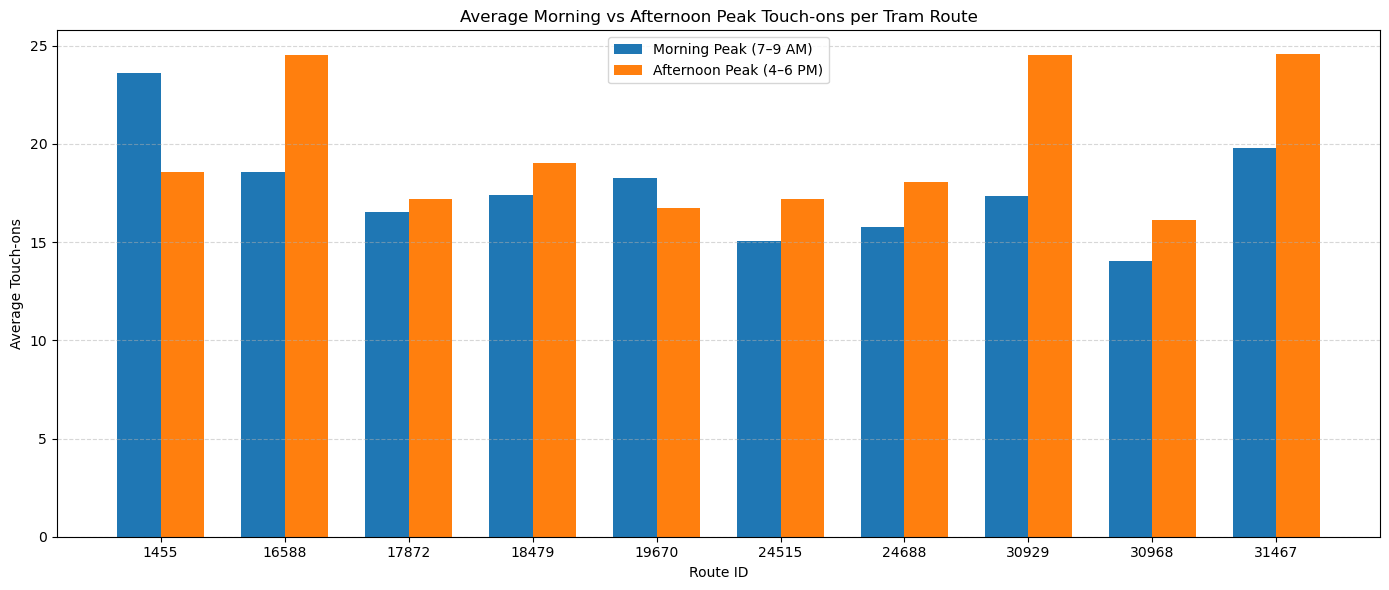

In [21]:
import numpy as np

plot_data = route_peaks[route_peaks["route_id"].isin(top10_routes["route_id"])]
plot_data = plot_data.sort_values("route_id")

routes = plot_data["route_id"].astype(str).values
x = np.arange(len(routes))

width = 0.35
plt.figure(figsize=(14, 6))

# Morning bar
plt.bar(
    x - width / 2,
    plot_data["avg_morning_touch_ons"],
    width,
    label="Morning Peak (7–9 AM)",
)

# Afternoon bar
plt.bar(
    x + width / 2,
    plot_data["avg_afternoon_touch_ons"],
    width,
    label="Afternoon Peak (4–6 PM)",
)

plt.xticks(x, routes)
plt.xlabel("Route ID")
plt.ylabel("Average Touch-ons")
plt.title("Average Morning vs Afternoon Peak Touch-ons per Tram Route")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [41]:
clean = final[final["stop_id_off"].notna()].copy()

clean["date_time_on"] = pd.to_datetime(clean["date_time_on"])
clean["date_time_off"] = pd.to_datetime(clean["date_time_off"])

clean["travel_time_min"] = (clean["date_time_off"] - clean["date_time_on"]).dt.total_seconds() / 60
clean = clean[(clean["travel_time_min"] > 0)]

print(clean.head(1))

  business_date   card_id  route_id  vehicle_id  stop_id_on  \
5    2017-01-04  16700780     17885         701       18449   

         date_time_on                      StopNameLong_on  stop_id_off  \
5 2017-01-04 07:50:33  32-Chapel St/Dandenong Rd (Windsor)      19678.0   

        date_time_off                                   StopNameLong_off  \
5 2017-01-04 07:59:55  20-Domain Interchange/St Kilda Rd (Melbourne C...   

   travel_time_min  
5         9.366667  


In [42]:
route_avg_time = (
    clean.groupby("route_id")["travel_time_min"]
    .mean()
    .reset_index(name="avg_travel_time_min")
    .sort_values("avg_travel_time_min", ascending=False)
)

top10_longest = route_avg_time.head(10)
print(top10_longest)


     route_id  avg_travel_time_min
689     24606           156.766667
288     17332           125.533333
262     17154           117.683333
329     17671           110.916667
502     19717           106.775000
618     24226            96.700000
619     24230            96.666667
123     15651            92.200000
242     17098            90.991667
282     17234            90.383333


   route_id  hour  avg_touch_ons
0      1413     0            5.0


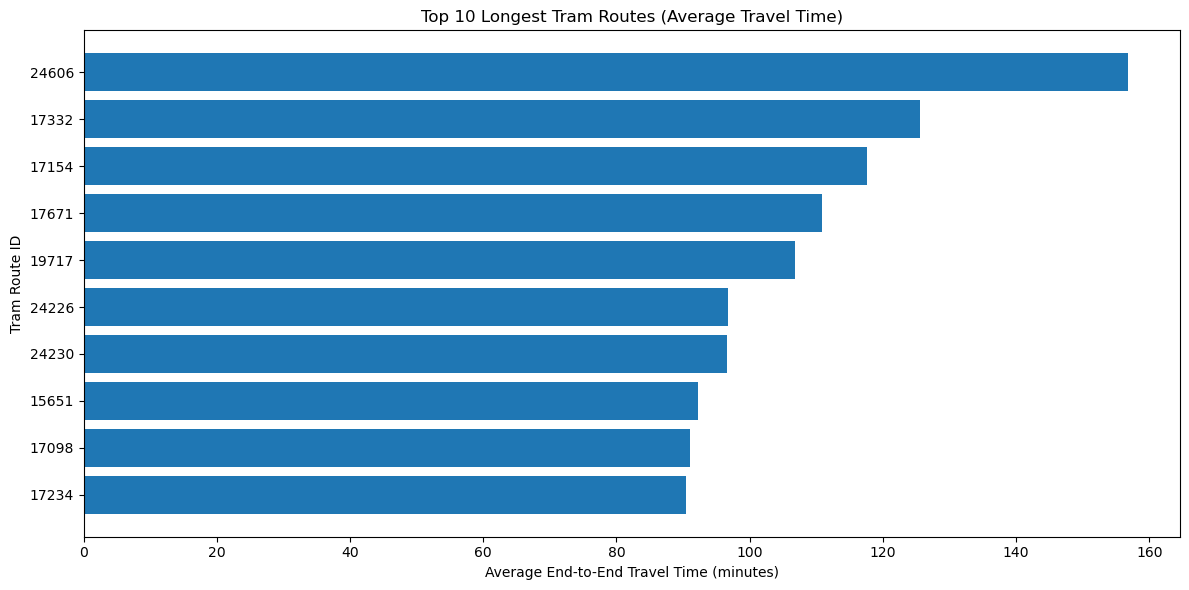

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(
    top10_longest["route_id"].astype(str),
    top10_longest["avg_travel_time_min"]
)

plt.xlabel("Average End-to-End Travel Time (minutes)")
plt.ylabel("Tram Route ID")
plt.title("Top 10 Longest Tram Routes (Average Travel Time)")
plt.gca().invert_yaxis()  # longest at the top
plt.tight_layout()
plt.show()


In [44]:
df = final.copy()

# convert to datetime
df["date_time_on"] = pd.to_datetime(df["date_time_on"])

# extract hour (0–23)
df["hour"] = df["date_time_on"].dt.hour

hourly_counts = (
    df.groupby(["route_id", "business_date", "hour"])
    .size()
    .reset_index(name="touch_on_count")
)
print(hourly_counts.head(1))

In [47]:
avg_hourly_route = (
    hourly_counts.groupby(["route_id", "hour"])["touch_on_count"]
    .mean()
    .reset_index(name="avg_touch_ons")
)

print(avg_hourly_route.head(1))

   route_id  hour  avg_touch_ons
0      1413     0            5.0


In [49]:
df = final.copy()
df["date_time_on"] = pd.to_datetime(df["date_time_on"])
df["hour"] = df["date_time_on"].dt.hour

In [50]:
hourly_counts = (
    df.groupby(["route_id", "business_date", "hour"])
    .size()
    .reset_index(name="touch_on_count")
)


In [51]:
morning = hourly_counts[hourly_counts["hour"].isin([7, 8, 9])]

avg_morning = (
    morning.groupby("route_id")["touch_on_count"]
    .mean()
    .reset_index(name="avg_morning_touch_ons")
)


In [52]:
afternoon = hourly_counts[hourly_counts["hour"].isin([16, 17, 18])]

avg_afternoon = (
    afternoon.groupby("route_id")["touch_on_count"]
    .mean()
    .reset_index(name="avg_afternoon_touch_ons")
)


In [54]:
route_peaks = avg_morning.merge(
    avg_afternoon,
    on="route_id",
    how="outer"
).fillna(0)

print(route_peaks.head(1))

   route_id  avg_morning_touch_ons  avg_afternoon_touch_ons
0      1413                    2.0                      7.0


https://yarratrams.com.au/route-guides